In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases import *
from dnn_utils import *

%matplotlib inline

plt.rcParams["figure.figsize"] = (5.0, 4.0)

plt.rcParams["image.interpolation"] = "nearset"

plt.rcParams["image.cmap"] = "gray"

np.random.seed(1)


In [2]:

train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes = load_data()

train_x = train_x_orig.reshape(train_x_orig.shape[0],-1).T/225

train_y = train_y_orig

test_x = test_x_orig.reshape(test_x_orig.shape[0], -1).T /225

test_y = test_y_orig

In [3]:
def initialize(dim_info):
    
    np.random.seed(1)
    
    parameters = {}
    
    dim_len = len(dim_info)
    
    for l in range(1, dim_len):
        
        parameters["W"+str(l)] = np.random.randn(dim_info[l], dim_info[l-1])*np.sqrt(2/dim_info[l - 1]) 
        
        # 将w进行简单归一化处理
        
        parameters["b"+str(l)] = np.zeros((dim_info[l], 1))
        
        
    return parameters

    
    

In [4]:
def line_forward(A, W, b):

    Z = np.dot(W, A) + b
    
    forward_Z_parameters = (A, W, b)
    print("W",W)
    
    return Z, forward_Z_parameters


In [5]:
def line_activate(A_prev, W, b, activation):
    
    Z, forward_Z_parameters = line_forward(A_prev, W, b)
    
    if activation == "sigmoid":
        A = sigmoid(Z)
    
    else:
        activation == "rule"
        A = relu(Z)
        
    forward_activation_parameters = (forward_Z_parameters, Z)
    
    return A, forward_activation_parameters
 

In [6]:
def line_model(X, parameters):
    
    forward_model_cache = []
    
    A = X
    
    layer_deep = len(parameters)//2
    
    for l in range(1,layer_deep): #  对网络层进行遍历 
        A_prev = A
        
        A, activation_parameters = line_activate(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], activation = "rule")
        # 输入层与隐藏层使用rule激活函数
        
        forward_model_cache.append(activation_parameters)
        
    Al, activation_parameters = line_activate(A, parameters["W"+str(layer_deep)], parameters["b"+str(layer_deep)], activation = 'sigmoid')
    # 输出层的Al参数
    
    forward_model_cache.append(activation_parameters)
    
    return Al, forward_model_cache
        
        
        
        

<span class="burk">正向传播使用droupout</span>

In [7]:
def line_model_droupout(X, parameters, dropout_num, seed, keep_dropout):
    # dropout对激活值进行使得A传到下一个神经元的的数随机失活从而实现预防网络过拟合的功能
    
    forward_model_cache = []
    
    random_dropout_cache = []
    
    layer_deep = len(parameters)//2
    
    A = X
    
    
    for l in range(1, layer_deep):
        A_prev = A
        
        A, activation_parameters = line_activate(A_prev, parameters["W"+str(l)], parameters["b"+str(l)],activation = 'rule')
        
        forward_model_cache.append(activation_parameters)
        
        if keep_dropout =="True":

            np.random.seed(seed+1)

            random_del = np.random.rand(A.shape[0], A.shape[1])
           
            zero_random = random_del < dropout_num # 失活百分比
            

            result_num = A * zero_random

            A = result_num / dropout_num # 使失活后的期望值与没失活之前的期望值保持一致
            
            random_dropout_cache.append(zero_random) # 将失活的比值储存 后面进行反向传播时再调用
        else: 
            continue
        
    Al, activation_parameters = line_activate(A, parameters["W"+str(layer_deep)], parameters["b"+str(layer_deep)], activation = 'sigmoid')
    
    
    forward_model_cache.append(activation_parameters)
    
    # 输出层不使用droupout失活 
    
    return Al, forward_model_cache, random_dropout_cache



In [8]:
def computer_cost(Al, Y):
    
    m = Y.shape[1]
    
    cost = (-1/m ) * np.sum(np.multiply(Y, np.log(Al)) + np.multiply(1 - Y, np.log(1 - Al)))
    
    return cost


In [9]:
def back_forward(dz, forward_Z_parameters):
    
    a_prev, W, b = forward_Z_parameters
    
    m = a_prev.shape[1]
    
    dW = np.dot(dz, forward_Z_parameters[0].T)/m
    
    db = np.sum(dz, axis=1, keepdims = True )/ m
    
    dA = np.dot(forward_Z_parameters[1].T, dz)
    
    return dA, dW, db



In [10]:
def line_activation_backward(dA, forward_model_cache, activation):
    
    linear_caches, activation_cache = forward_model_cache
    
    if activation == "relu":
        dz = relu_backward(dA, activation_cache)
        
    else:
        activation == "sigmoid"
        dz = sigmoid_backward(dA, activation_cache)
        
    da_prev, dw, db = back_forward(dz, linear_caches)
    # 根据这一步得出来的dz 算出上一网络层的偏导数da 与当前网络层的偏导数dw， db
    
    return da_prev, dw, db

        
        
        

In [11]:
def line_model_backward(Al, y, forward_model_cache ):
    
    grades = {}
    
    l = len(forward_model_cache)
    
    m = y.shape[1]
    
    y = y.reshape(Al.shape)
    
    dal = -(np.divide(y, Al) - np.divide(1-y, 1-Al))
    
    last_layer_parameters = forward_model_cache[-1]
    
    grades["dA"+str(l-1)], grades["dW"+str(l)], grades["db"+str(l)] = line_activation_backward(dal, last_layer_parameters, activation='sigmoid')

    # 根据da得出倒数第二层的dA,跟倒数第一层的dW，db
    
    
    for i in reversed(range(1, l)):
        grades["dA"+str(i - 1)],grades['dW'+str(i)], grades["db"+str(i)] = line_activation_backward(grades["dA"+str(i)], forward_model_cache[i-1], activation = 'relu')
        
        
    return grades

    
    

<span class="burk"># 反向失活函数</span>

In [12]:
def line_modle_backward_droupout(Al, y, forward_model_cache, dropout_cache, keep_dropout, drop_num = 0.5):
    
    grades = {}
    
    l = len(forward_model_cache)

    m = y.shape[1]
    
    y = y.reshape(Al.shape)
    
    # dal = -(np.divide(y, Al)) - np.divide(1-y, 1-Al)
    
    dal = -(np.divide(y, Al) - np.divide(1-y, 1-Al))
    
    last_layer_parameters = forward_model_cache[-1]
    
    grades["dA"+str(l - 1)], grades["dW"+ str(l)], grades['db'+str(l)] = line_activation_backward(dal, last_layer_parameters, activation='sigmoid')
 

    for i in reversed(range(1, l)):
        grades['dA'+ str(i - 1)], grades["dW"+str(i)], grades["db"+str(i)] = line_activation_backward(grades['dA'+ str(i)], forward_model_cache[i - 1], activation ='relu' )

        if keep_dropout =="True" and i != 1: 
            # 这里只对隐藏层进行反向的dropout梯度计算 在前向传播时也只对隐藏层进行dropout
        
            grades['dA'+ str(i - 1)] = grades["dA"+str(i - 1)] * dropout_cache[i - 2]

            grades["dA"+ str(i - 1)] = grades['dA'+str(i - 1)] / drop_num # 使期望值保持一致
            
        else:
            continue
    
     
    return grades 
    

In [13]:
def updata_parameters(parameters, grads, learning_rate):
    
    L = len(parameters)//2

    for i in range(1,L+1):
        
        parameters["W"+ str(i)] = parameters["W"+ str(i)] - grads['dW'+str(i)]*learning_rate
        
        
        parameters["b"+str(i)] = parameters["b"+str(i)] - grads['db'+str(i)]*learning_rate
    
        
    return parameters
            
    
    
    

<span class="burk">Adam初始化参数</span>

In [14]:
def initialize_Adam(parameters):
    
    L = len(parameters)//2
    
    v = {}
    
    s = {}
    
    for l in range(L):
        v['dW'+str(l + 1)] = np.zeros_like(parameters['W'+str(l + 1)])
        v["db"+str(l + 1)] = np.zeros_like(parameters["b"+str(l + 1)])
        
        s["dW"+str(l + 1)] = np.zeros_like(parameters["W"+str(l + 1)])
        s["db"+str(l + 1)] = np.zeros_like(parameters["b"+str(l + 1)])
        
    return v, s

<span class="burk">Aadm梯度下降</span>

In [15]:
def updata_parameters_Adam(parameters, grads, learning_rate, v, s, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8,  keep_Adam = "True"):
    
    # 这里使用Aadm梯度下降是要注意是对更新函数时的梯度进行Aadm修正
    
    L = len(parameters) // 2
    
    v_corrected = {}
    
    s_corrected = {}
    
    # for i in range(L):
        # v['dW'+str(i + 1)] = np.zeros_like(grads['dW'+str(i + 1)])
        # v["db"+str(i + 1)] = np.zeros_like(grads["db"+str(i + 1)])
        
        # s["dW"+str(i + 1)] = np.zeros_like(grads["dW"+str(i + 1)])
        # s["db"+str(i + 1)] = np.zeros_like(grads["db"+str(i + 1)])
        
    if keep_Adam == "True":
        
        
        for l in range(L - 1):
            v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
            v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]
        

            # 对v值进行修正
            v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, 2))
            v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, 2))
        

            # 算出s值
            s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
            s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)
    

            # 对s值进行修正
            s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, 2))
            s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, 2))
 

            # 更新参数
            parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
            parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)
            
            # print('gradsdW'+str(l+1),grads["dW"+str(l+1)]) # 梯度4值异常增大
            
            # v['dW'+str(l + 1)] = beta1 * grads["dW"+str(l + 1)] + (1 - beta1) * grads["dW"+str(l + 1)]
            # v['db'+str(l + 1)] = beta1 * grads["db"+str(l + 1)] + (1 - beta1) * grads["db"+str(l + 1)]
            
            # v_corrected["dW"+str(l + 1)] = v["dW"+str(l + 1)] / np.power(1 - beta1, 2) # 修正函数
            # v_corrected["db"+str(l + 1)] = v["db"+str(l + 1)] / np.power(1 - beta1, 2)
            
            # s['dW'+str(l + 1)] = beta2 * grads['dW'+str(l + 1)] + (1 - beta2) * np.power(grads["dW"+str(l + 1)], 2) # 进行RSM 后面与指数加平均的区别是后面是乘梯度的平方
            # s['db'+str(l + 1)] = beta2 * grads["db"+str(l + 1)] + (1 - beta2) * np.power(grads["db"+str(l + 1)], 2)
            
            # s_corrected['dW'+str(l + 1)] = s["dW"+str(l + 1)] / np.power(1 - beta2, 2) # 进行数值修正
            # s_corrected['db'+str(l + 1)] = s['db'+str(l + 1)] / np.power(1 - beta2, 2)
            # print('s_corrected[dW]'+str(l + 1),s_corrected["dW"+str(l + 1)])
             
            # parameters["W"+str(l + 1)] = parameters['W'+str(l + 1)] - learning_rate * v_corrected["dW"+str(l + 1)] / np.sqrt(s_corrected["dW"+str(l + 1)] + epsilon)
            # parameters['b'+str(l + 1)] = parameters["b"+str(l + 1)] - learning_rate * v_corrected['db'+str(l + 1)] / np.sqrt(s_corrected["db"+str(l + 1)] + epsilon)
            
            
            # print('np.sqrt(s_corrected["dW"+str(l + 1)] + epsilon)'+str(l),np.sqrt(s_corrected["dW"+str(l + 1)] + epsilon))
    else:
        keep_Adam == 'False'
        for l in range(L):
            parameters["W"+str(l + 1)] = parameters["W"+str(l + 1)] - learning_rate * grads["dW"+str(l + 1)]
            parameters['b'+str(l + 1)] = parameters["b"+str(l + 1)] - learning_rate * grads["db"+str(l + 1)]
            
            

    return parameters


In [16]:
def dnn_model(x,
              y,
              dim_info,
              learning_rate = 0,
              keep_Adam = "True",
              move_change_rate='True',
              num_iterations=100,
              print_cost=True,
              dropout_num=1,
              keep_dropout ='True',
              decay_rate=0.5,
              beta1=0.9,
              beta2=0.999,
              epsilon=1e-8):

    # decay_rate 动量梯度下降超参数

    np.random.seed(1)
    costs = []
    m = y.shape[1]

    parameters = initialize(dim_info)

    seed = 0

    for i in range(0, num_iterations):

        # Al, forward_model_cache = line_model(x, parameters)
        seed += 1
        # 进行deopout前向传播
        Al, forward_model_cache, dropout_cache = line_model_droupout(x, parameters, dropout_num, seed, keep_dropout)

        cost = computer_cost(Al, y)

        # grades = line_model_backward(Al, y, forward_model_cache) # 进行反向传播
        
        
        # 进行反向传播的dropout
        grades = line_modle_backward_droupout(Al, y, forward_model_cache,
                                              dropout_cache, keep_dropout,
                                              dropout_num)
        
        

        # 动态梯度下降
        if i % 500 == 0 and move_change_rate == "True":

            epoch_num = i // 500
            print('epoch_num:', epoch_num)

            learning_rate = 1 / (1 + decay_rate * epoch_num) * learning_rate

            print('learning_rate:', learning_rate)
            
            
            
            
        # 初始化Adam里面的参数值v，s
        if i == 0:
            v, s = initialize_Adam(parameters) 
        else:
            v = v
            s = s
        # parameters = updata_parameters(parameters, grades, learning_rate)
        
        
        # 使用Adam算法更新参数
        parameters = updata_parameters_Adam(parameters,
                                            grades,
                                            learning_rate,
                                            v,
                                            s,
                                            beta1=0.9,
                                            beta2=0.999,
                                            epsilon=1e-8,
                                            keep_Adam = keep_Adam,
                                            )
        
        

        if i % 100 == 0:
            if print_cost and i > 0:
                print('训练%i次后的成本是: %f' % (i, cost))
                # print(dropout_cache[1])
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations(per tens)')
    plt.title('Learning rate =' + str(learning_rate))

    plt.show()

    return parameters

W [[ 2.07230068e-02 -7.80464094e-03 -6.73828797e-03 ... -6.72607169e-03
  -4.85228182e-03  1.21123744e-02]
 [ 1.28755274e-02  2.93286842e-03 -8.47241628e-03 ...  8.80105305e-03
  -6.22989498e-03  2.64863484e-03]
 [-4.54609730e-03 -2.49389738e-03  8.12417579e-03 ...  1.04964637e-02
  -1.33223214e-03 -8.39405327e-03]
 ...
 [-1.55840316e-02 -1.27932518e-02 -3.93125912e-03 ...  9.05152235e-03
   1.10563587e-02  5.20812981e-03]
 [ 1.62777349e-02 -1.64851242e-02 -1.52971730e-02 ...  1.79031201e-03
  -6.07919283e-03 -2.46479539e-02]
 [ 1.99467042e-02 -1.31221513e-02 -6.38725586e-03 ... -8.93562691e-03
  -9.37417987e-03 -9.57161851e-05]]
W [[-0.3488544  -0.01648169  0.54338216  0.06978001 -0.11922547 -0.04351715
   0.14469511  0.37737113  0.05413949 -0.26060988 -0.11400781 -0.35470754
   0.1999769  -0.17919647 -0.07338487 -0.4714952   0.17504837 -0.35600398
   0.06979525  0.05983986 -0.56757851 -0.35257633 -0.15559179  0.0110146
   0.1976659  -0.04016948  0.28097652 -0.17474345  0.0097683  -0.

/Users/sandy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/sandy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/Users/sandy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/sandy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/sandy/Desktop/3深度神经网络/dnn_utils.py:77: RuntimeWarning: invalid value encountered in multiply
  dZ = dA * s * (1-s)


W [[-0.00215175 -0.03067945 -0.0296129  ... -0.02960086 -0.02772694
  -0.01076032]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.03845868 -0.03566782 -0.0268053  ... -0.01382111 -0.01181705
  -0.01766418]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01810601 -0.01496284 -0.00822795 ... -0.02412474 -0.02329509
  -0.00712503]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.01940959 -0.04793732 -0.04687062 ... -0.04685873 -0.0449847
  -0.0280166 ]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.05571644 -0.05292552 -0.04406259 ... -0.03107733 -0.02907386
  -0.03492017]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.0167213  -0.01634755 -0.00961266 ... -0.03556558 -0.03377855
  -0.01241439]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan

W [[-0.02845401 -0.05698176 -0.05591498 ... -0.05590316 -0.05402907
  -0.03706019]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.06476082 -0.06196986 -0.05310672 ... -0.0401209  -0.03811774
  -0.0439636 ]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01599826 -0.0170706  -0.0103357  ... -0.04154905 -0.03925989
  -0.01517717]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03236295 -0.0608907  -0.05982389 ... -0.0598121  -0.05793799
  -0.04096877]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.06866974 -0.06587876 -0.05701553 ... -0.04402946 -0.04202644
  -0.04787211]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01568701 -0.01738185 -0.01064695 ... -0.04412924 -0.04162289
  -0.0163669 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03405236 -0.06258012 -0.0615133  ... -0.06150152 -0.0596274
  -0.04265803]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07035914 -0.06756816 -0.05870489 ... -0.04571872 -0.04371575
  -0.04956134]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01555302 -0.01751584 -0.01078094 ... -0.04524186 -0.04264156
  -0.01687922]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan

W [[-0.03478252 -0.06331028 -0.06224345 ... -0.06223167 -0.06035755
  -0.04338812]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.0710893  -0.06829831 -0.05943502 ... -0.0464488  -0.04444586
  -0.05029142]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01549534 -0.01757352 -0.01083862 ... -0.04572164 -0.04308071
  -0.01709984]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03509809 -0.06362584 -0.06255901 ... -0.06254724 -0.06067312
  -0.04370365]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07140486 -0.06861388 -0.05975058 ... -0.04676434 -0.04476141
  -0.05060695]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01547051 -0.01759835 -0.01086345 ... -0.04592852 -0.04327002
  -0.01719485]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

  nan nan nan nan nan nan nan nan nan nan nan nan]]
W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03523447 -0.06376223 -0.0626954  ... -0.06268363 -0.0608095
  -0.04384003]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07154125 -0.06875026 -0.05988696 ... -0.04690071 -0.04489779
  -0.05074332]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545982 -0.01760903 -0.01087414 ... -0.04601773 -0.04335163
  -0.01723576]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan

W [[-0.03528295 -0.06381071 -0.06274387 ... -0.06273211 -0.06085798
  -0.0438885 ]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07158972 -0.06879874 -0.05993543 ... -0.04694918 -0.04494626
  -0.05079179]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545604 -0.01761282 -0.01087792 ... -0.04604938 -0.04338057
  -0.01725025]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03531437 -0.06384213 -0.06277529 ... -0.06276353 -0.0608894
  -0.04391992]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07162114 -0.06883016 -0.05996685 ... -0.0469806  -0.04497768
  -0.05082321]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545359 -0.01761527 -0.01088037 ... -0.04606985 -0.04339928
  -0.01725962]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan

W [[-0.03532795 -0.06385571 -0.06278887 ... -0.0627771  -0.06090298
  -0.04393349]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07163472 -0.06884374 -0.05998043 ... -0.04699418 -0.04499126
  -0.05083679]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545254 -0.01761632 -0.01088142 ... -0.04607867 -0.04340735
  -0.01726365]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

W [[-0.0353359  -0.06386366 -0.06279683 ... -0.06278506 -0.06091093
  -0.04394145]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164268 -0.06885169 -0.05998838 ... -0.04700213 -0.04499921
  -0.05084474]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545192 -0.01761693 -0.01088204 ... -0.04608383 -0.04341206
  -0.017266  ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533726 -0.06386501 -0.06279818 ... -0.06278641 -0.06091229
  -0.0439428 ]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164403 -0.06885304 -0.05998974 ... -0.04700349 -0.04500056
  -0.05084609]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545182 -0.01761704 -0.01088214 ... -0.0460847  -0.04341286
  -0.0172664 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533784 -0.0638656  -0.06279877 ... -0.062787   -0.06091287
  -0.04394338]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164461 -0.06885363 -0.05999032 ... -0.04700407 -0.04500115
  -0.05084668]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545178 -0.01761708 -0.01088218 ... -0.04608508 -0.0434132
  -0.01726657]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan

W [[-0.03533807 -0.06386583 -0.062799   ... -0.06278723 -0.0609131
  -0.04394362]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164485 -0.06885386 -0.05999055 ... -0.0470043  -0.04500138
  -0.05084691]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545176 -0.0176171  -0.0108822  ... -0.04608523 -0.04341334
  -0.01726664]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan

W [[-0.03533818 -0.06386594 -0.06279911 ... -0.06278734 -0.06091321
  -0.04394373]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164496 -0.06885397 -0.05999066 ... -0.04700441 -0.04500149
  -0.05084702]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545175 -0.01761711 -0.01088221 ... -0.0460853  -0.0434134
  -0.01726667]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan

W [[-0.03533824 -0.063866   -0.06279917 ... -0.0627874  -0.06091327
  -0.04394379]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164502 -0.06885403 -0.05999072 ... -0.04700447 -0.04500155
  -0.05084708]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608533 -0.04341344
  -0.01726669]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533827 -0.06386602 -0.06279919 ... -0.06278742 -0.0609133
  -0.04394381]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164504 -0.06885405 -0.05999075 ... -0.0470045  -0.04500157
  -0.0508471 ]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608535 -0.04341345
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan

W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.0627992  ... -0.06278743 -0.06091331
  -0.04394382]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164505 -0.06885407 -0.05999076 ... -0.04700451 -0.04500158
  -0.05084711]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan 

  nan nan nan nan nan nan nan nan nan nan nan nan]]
W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999076 ... -0.04700451 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999076 ... -0.04700451 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700451 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700451 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

  nan nan nan nan nan nan nan nan nan nan nan nan]]
W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan na

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

  nan nan nan nan nan nan nan nan nan nan nan nan]]
W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan na

W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan 

  nan nan nan nan nan nan nan nan nan nan nan nan]]
W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan na

W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

  nan nan nan nan nan nan nan nan nan nan nan nan]]
W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan na

W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan 

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

  nan nan nan nan nan nan nan nan nan nan nan nan]]
W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

  nan nan nan nan nan nan nan nan nan nan nan nan]]
W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]
W [[-0.22821308  0.45435184  0.32636984  0.60864087  0.08317317  0.23551671]]
W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan 

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

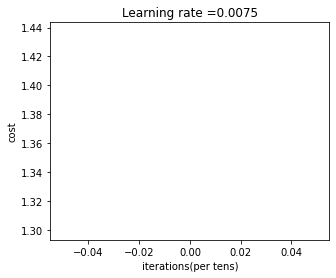

In [17]:
dim_info = [12288, 30, 8, 6, 1]


parameters = dnn_model(train_x, train_y, dim_info, learning_rate=0.0075, move_change_rate = 'False',  num_iterations = 500, print_cost = True, dropout_num = 0.5, keep_dropout = "True", decay_rate = 0.5, beta1 = 0.5, beta2 = 0.999, keep_Adam = 'True', epsilon = 1e-8)





In [18]:
def predict(X, parameters):
    m = X.shape[1]
    
    n = len(parameters) //2
    
    p = np.zeros((1,m))
    
    probas, caches = line_model(X, parameters) # 这里要记住在实际预测时要把droupout关闭在进行预测
    
    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
            
    return p
    
    

In [19]:
pred_train = predict(train_x, parameters)

print('预测集的准确率是:'+str(np.sum((pred_train == train_y) / train_x.shape[1])))


W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na

In [20]:
pred_test = predict(test_x, parameters)

print('测试集的准确率是:'+str(np.sum((pred_test == test_y) / test_x.shape[1])))

W [[-0.03533828 -0.06386604 -0.06279921 ... -0.06278744 -0.06091331
  -0.04394383]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.07164506 -0.06885407 -0.05999077 ... -0.04700452 -0.04500159
  -0.05084712]
 [        nan         nan         nan ...         nan         nan
          nan]
 [ 0.01545174 -0.01761711 -0.01088222 ... -0.04608536 -0.04341346
  -0.0172667 ]]
W [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [na